# Model_3_Pose_Estimation_YOLO_NAS

# Introduction

Source: https://github.com/Deci-AI/super-gradients/blob/master/YOLONAS-POSE.md

Dataset used: COCO-Pose dataset (https://cocodataset.org/#keypoints-2017)

| Metric         | AP      | 	Latency (ms) |
|----------------|---------|---------------|
| YOLO-NAS N     | 	59.68  | 2.35 ms       |
| YOLO-NAS S     | 	64.15  | 3.29 ms       |
|YOLO-NAS M      | 67.87   | 6.87 ms       |
|YOLO-NAS L      | 68.24   | 8.86 ms       |


Metric source: https://github.com/Deci-AI/super-gradients/blob/master/YOLONAS-POSE.md

In [1]:
%%capture
!pip install super-gradients
!pip install -U git+https://github.com/ytdl-org/youtube-dl.git

In [2]:
import torch
import os
import pathlib
import re
from imutils import paths
from IPython.display import YouTubeVideo

In [3]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

yolo_nas_pose = models.get("yolo_nas_pose_l", pretrained_weights="coco_pose").cuda()

[2024-05-17 02:10:15] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-05-17 02:10:20] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-05-17 02:10:23] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco_pose dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-05-17 02:10:23] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-05-17 02:10:23] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_pose_l


In [10]:
yolo_nas_pose

YoloNASPose_L(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=1e-06, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=1e-06, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=1e-06, momentum=0.03, affin

In [4]:
yolo_nas_pose = models.get("yolo_nas_pose_l", pretrained_weights="coco_pose")

[2024-05-17 02:10:27] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco_pose dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-05-17 02:10:27] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-05-17 02:10:28] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_pose_l


In [5]:

def make_prediction(input_file, action, confidence=0.55):
    """
    Make a prediction using the fixed model and device, and either show or save the result.

    Args:
    - input_file (str): Path to the input file.
    - action (str): Either 'show' or 'save'.
    - confidence (float, optional): Confidence threshold. Defaults to 0.75.

    Returns:
    - None

    Raises:
    - ValueError: If the action is not 'show' or 'save'.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if action == "show":
        yolo_nas_pose.to(device).predict(input_file, conf=confidence).show()
    elif action == "save":
        output_file = pathlib.Path(input_file).stem + "-detections" + pathlib.Path(input_file).suffix
        yolo_nas_pose.to(device).predict(input_file, conf=confidence).save(output_file)
        print(f"Prediction saved to {output_file}")
    else:
        raise ValueError("Action must be either 'show' or 'save'.")

[2024-05-17 02:10:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


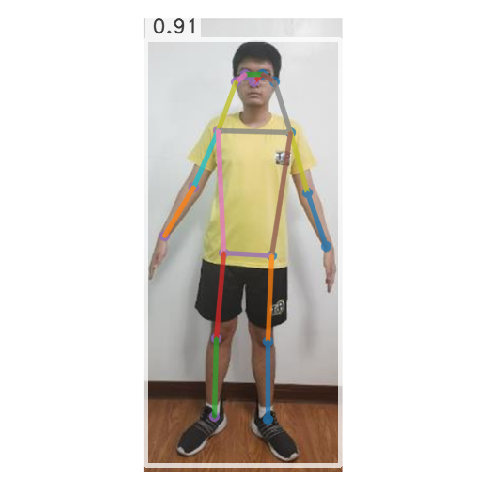

In [6]:
url = "https://raw.githubusercontent.com/Abyza/Project_Exercise_Posture_Correction/main/Creation_of_Models/Sample_Images/paulo3.png"
make_prediction(url, "show")

In [7]:
def process_single_image(image_prediction):
    """
    Process a single image prediction to visualize the pose estimation results on a blank background.

    Parameters:
    - image_prediction : object
        An instance containing the image and its associated pose prediction data.

    Returns:
    - np.ndarray
        An image with the pose skeleton drawn.
    """

    image = image_prediction.image
    pose_data = image_prediction.prediction

    blank_image = np.zeros_like(image)  # for a black background

    skeleton_image = PoseVisualization.draw_poses(
        image=blank_image,
        poses=pose_data.poses,
        boxes=pose_data.bboxes_xyxy,
        scores=pose_data.scores,
        is_crowd=None,
        edge_links=pose_data.edge_links,
        edge_colors=pose_data.edge_colors,
        keypoint_colors=pose_data.keypoint_colors,
        joint_thickness=2,
        box_thickness=2,
        keypoint_radius=5
    )
    return skeleton_image

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from super_gradients.training.utils.visualization.detection import draw_bbox
from super_gradients.training.utils.visualization.pose_estimation import PoseVisualization

[2024-05-17 02:10:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


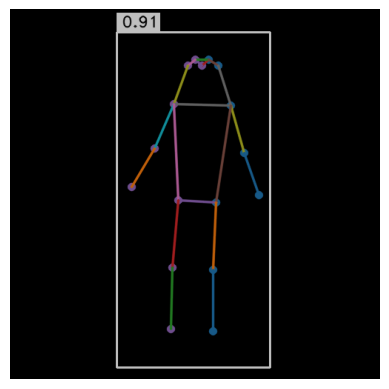

In [9]:
jumpman = yolo_nas_pose.to('cuda').predict(url, conf=.55)

image_prediction = jumpman # Assuming you have just a single image

skeleton_image = process_single_image(image_prediction)

plt.imshow(skeleton_image)
plt.axis('off')
plt.show()